In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Load Data

In [33]:
train_data = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv') 
test_data = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/test.csv')

In [34]:
train_data.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [35]:
#create file path
train_data["file_path"] = train_data["Id"].apply(lambda identifier: "/kaggle/input/petfinder-pawpularity-score/train/" + identifier + ".jpg")
test_data["file_path"] = test_data["Id"].apply(lambda identifier: "/kaggle/input/petfinder-pawpularity-score/test/" + identifier + ".jpg")

# Visualize train_image

(720, 405, 3)


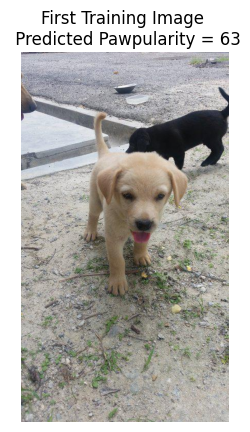

In [36]:
for i, image_path in enumerate(train_data['file_path'][:1]):
    training_example_image = plt.imread(image_path)
    print(training_example_image.shape)
    plt.imshow(training_example_image)
    plt.title('First Training Image \n Predicted Pawpularity = {}'.format(train_data['Pawpularity'].iloc[i]))
    plt.axis('off')
    plt.show()

# Features list

In [37]:
feature_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
image_size = 128
batch_size = 32

# Preprocessing data

In [38]:
def preprocess(image_url, feature):
    # Read and decode the image
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)

    # Convert image to float and normalize
    image = tf.cast(image, tf.float32) / 255.0

    # Perform central crop and resize
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))

    # Return preprocessed image and feature data
    # (excluding the first element), along with the label
    return (image, feature[1:]), tf.cast(feature[0], tf.float32)

# Build feature model

In [39]:
def build_feature_model(inputs): # model for the features
    # Hyperparameters
    width = 64
    depth = 3
    activation = "relu"
    dropout = 0.1

    # Initial dense layer
    x = keras.layers.Dense(width, activation=activation)(inputs)

    # Building the model with multiple dense, dropout, and batch normalization layers
    for i in range(depth):
        if i == 0:
            x = inputs  # No need to reassign inputs in the first iteration
        x = keras.layers.Dense(width, activation=activation)(x)
        x = keras.layers.Dropout(dropout)(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Concatenate()([x, inputs])

    return x


# Define rmse

In [40]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true -  y_pred) ** 2))

# Define Block function

In [41]:
#a block of convolutional layers followed by max pooling in a neural network
def block(x, filters, kernel_size, repetitions, pool_size=2, strides=2):
    for i in range(repetitions):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)
    return x

# Define  model 

In [42]:
def get_model():
    # Input layers
    image_inputs = tf.keras.Input((image_size, image_size, 3))
    feature_inputs = tf.keras.Input(len(feature_columns))

    # Image branch
    image_x = block(image_inputs, 8, 3, 2)
    image_x = block(image_x, 16, 3, 2)
    image_x = block(image_x, 32, 3, 2)
    image_x = block(image_x, 64, 3, 2)
    image_x = block(image_x, 128, 3, 2)
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)

    # Feature branch (assuming build_feature_model is defined elsewhere)
    feature_x = build_feature_model(feature_inputs)

    # Concatenate image and feature branches
    x = tf.keras.layers.Concatenate(axis=1)([image_x, feature_x])

    # Output layer
    output = tf.keras.layers.Dense(1)(x)

    # Create and return the model
    model = tf.keras.Model(inputs=[image_inputs, feature_inputs], outputs=[output])
    return model

# Plot model

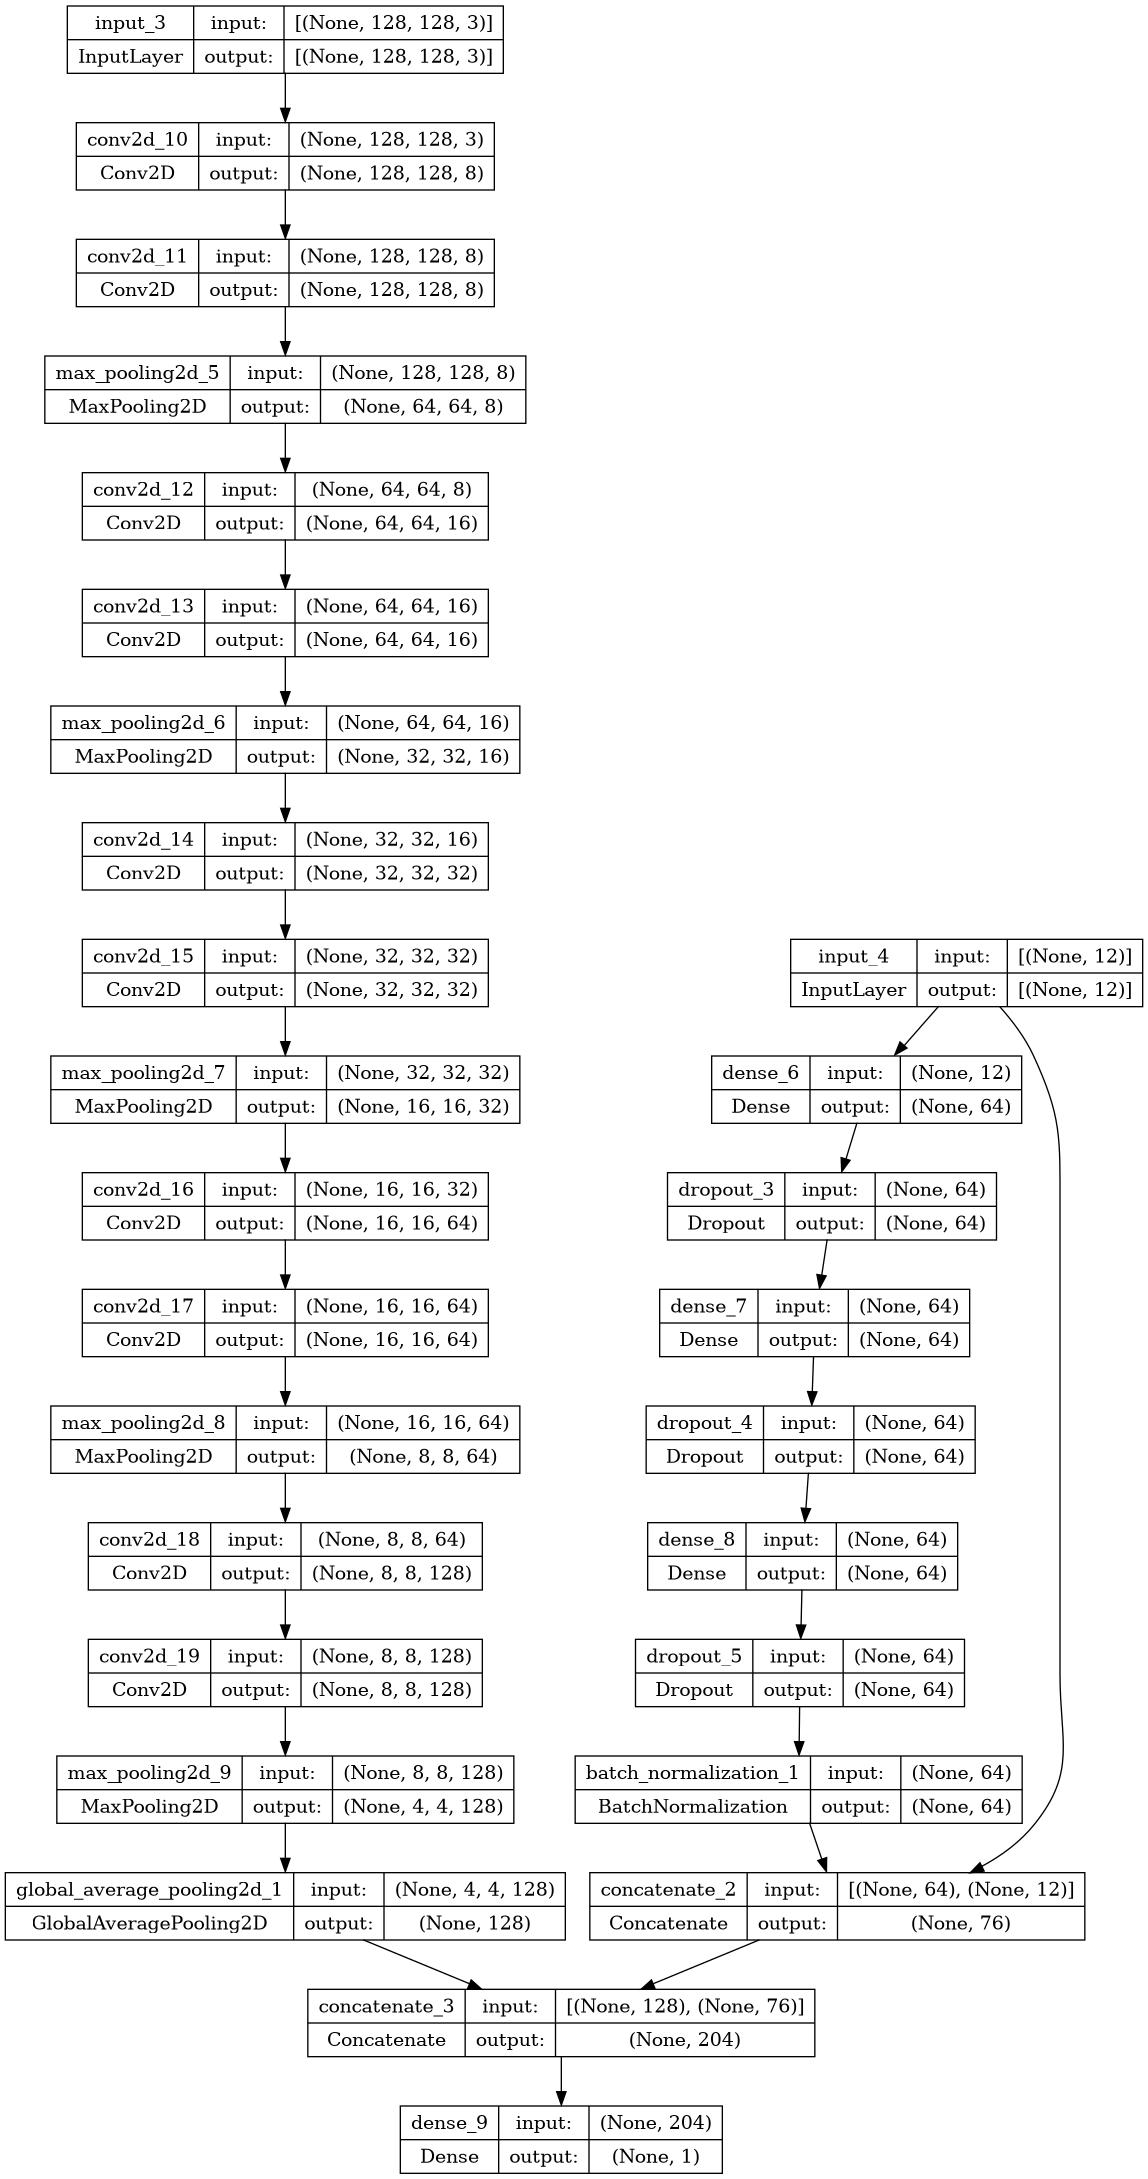

In [43]:
model = get_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [44]:
# Generate random image data
image = np.random.normal(size=(1, image_size, image_size, 3))
feature = np.random.normal(size=(1, len(feature_columns)))
print(image.shape, feature.shape)
print(model((image, feature)).shape)

(1, 128, 128, 3) (1, 12)
(1, 1)


# Train Model

Epoch 1/300
248/248 [==============================] - 28s 86ms/step - loss: 523.6454 - mae: 17.0576 - rmse: 22.4112 - mape: 80.1678 - val_loss: 562.4686 - val_mae: 19.7660 - val_rmse: 23.5812 - val_mape: 106.9968 - lr: 0.0010
Epoch 2/300
  6/248 [..............................] - ETA: 2s - loss: 611.0892 - mae: 19.5246 - rmse: 24.4468 - mape: 112.4864

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 3s 12ms/step - loss: 707.3962 - mae: 16.9939 - rmse: 22.3109 - mape: 82.5130 - val_loss: 870.9554 - val_mae: 22.0251 - val_rmse: 29.1034 - val_mape: 59.8094 - lr: 0.0010
Epoch 3/300
248/248 [==============================] - 3s 12ms/step - loss: 828.6204 - mae: 18.5625 - rmse: 24.1680 - mape: 82.2086 - val_loss: 569.1136 - val_mae: 19.4159 - val_rmse: 23.6971 - val_mape: 101.4423 - lr: 0.0010
Epoch 4/300
248/248 [==============================] - 3s 12ms/step - loss: 818.8184 - mae: 17.3596 - rmse: 22.8538 - mape: 83.0663 - val_loss: 500.5072 - val_mae: 15.9031 - val_rmse: 21.9530 - val_mape: 66.6375 - lr: 3.0000e-04
Epoch 5/300
248/248 [==============================] - 3s 12ms/step - loss: 473.2432 - mae: 16.2249 - rmse: 21.4446 - mape: 78.4933 - val_loss: 491.1745 - val_mae: 15.8870 - val_rmse: 21.7602 - val_mape: 68.6000 - lr: 3.0000e-04
Epoch 6/300
248/248 [==============================] - 3s 12ms/step - loss: 468.4694 - mae: 16.1403 - r

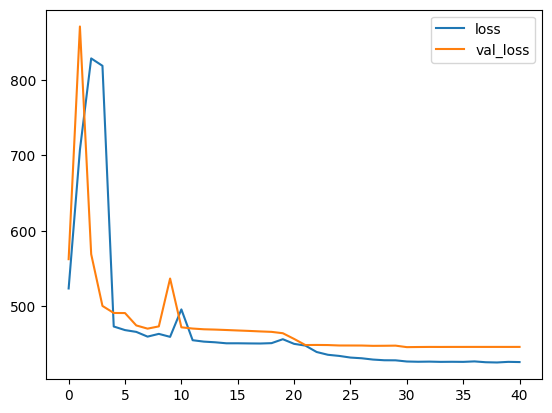

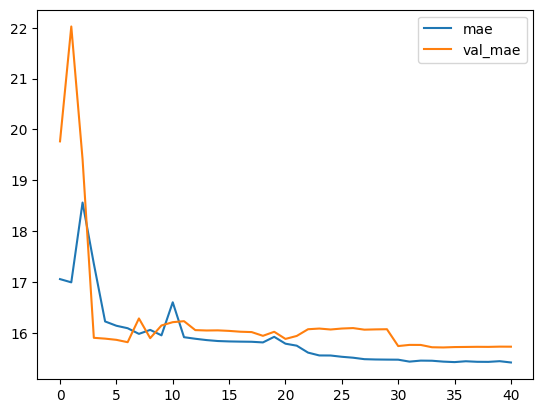

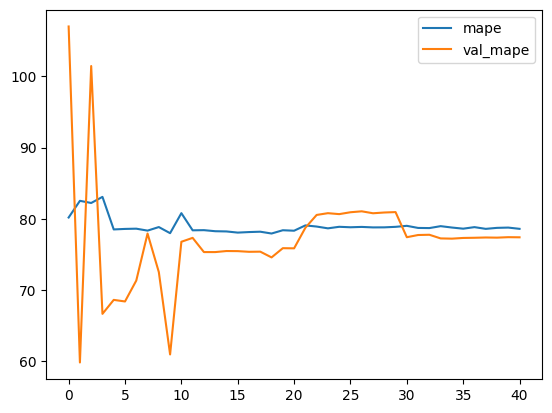

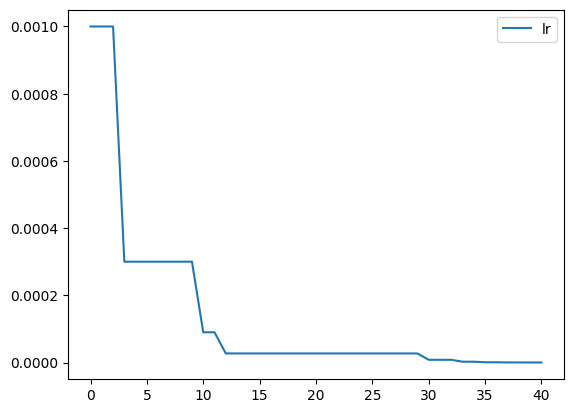

In [45]:
tf.keras.backend.clear_session()

models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# For the current random state, 5th fold can generate a better validation rmse and faster convergence.
train_best_fold = True
best_fold = 0


for index, (train_indices, val_indices) in enumerate(kfold.split(train_data)):#model training loop
    if train_best_fold and index != best_fold:
        continue

    #Data Splitting
    x_train = train_data.loc[train_indices, "file_path"]
    feature_train = train_data.loc[train_indices, ["Pawpularity"] + feature_columns]
    x_val= train_data.loc[val_indices, "file_path"]
    feature_val = train_data.loc[val_indices, ["Pawpularity"] + feature_columns]

    #call backs
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        min_delta=1e-4, 
        patience=10
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=2, 
        min_lr=1e-7
    )
    callbacks = [early_stop, checkpoint, reduce_lr]
    
    #model complilation 
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    #Data Preparation 
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, feature_train)).map(preprocess).shuffle(512).batch(batch_size).cache().prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, feature_val)).map(preprocess).batch(batch_size).cache().prefetch(2)

    #training model
    model = get_model()
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse, "mape"])
    history = model.fit(train_ds, epochs=300, validation_data=val_ds, callbacks=callbacks)

    #Visualization for performance
    for metrics in [("loss", "val_loss"), ("mae", "val_mae"), ("mape", "val_mape"), ["lr"]]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()

    #load best model
    model.load_weights(checkpoint_path)

    #storing history and model
    historys.append(history)
    models.append(model)

# Process test_data

In [46]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [47]:
test_ds = (
    tf.data.Dataset
    .from_tensor_slices((test_data["file_path"], test_data[feature_columns]))
    .map(preprocess_test_data)  # Apply the preprocess_test_data function to each element
    .batch(batch_size)  # Combine elements into batches of the specified size
    .cache()  # Cache the dataset for faster retrieval
    .prefetch(2)  # Prefetch batches to speed up training
)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


# Predict the test_image

In [48]:
sample_submission = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/sample_submission.csv')

In [49]:
use_best_result = False
if use_best_result:
    if train_best_fold:
        best_model = models[0]
    else:
        best_fold = 0
        best_score = 10e8
        for fold, history in enumerate(historys):
            for val_rmse in history.history["val_rmse"]:
                if val_rmse < best_score:
                    best_score = val_rmse
                    best_fold = fold
        print("Best Score:%.2f Best Fold: %d"%(best_score, best_fold + 1))
        best_model = models[best_fold]
    results = best_model.predict(test_ds).reshape(-1)
else:
    total_results = []
    for model in models:
        total_results.append(model.predict(test_ds).reshape(-1))
    results = np.mean(total_results, axis=0).reshape(-1)
sample_submission["Pawpularity"] = results

1/1 [==============================] - 0s 189ms/step


In [50]:
sample_submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,51.474758
1,43a2262d7738e3d420d453815151079e,49.274502
2,4e429cead1848a298432a0acad014c9d,48.546444
3,80bc3ccafcc51b66303c2c263aa38486,29.544247
4,8f49844c382931444e68dffbe20228f4,29.583454
5,b03f7041962238a7c9d6537e22f9b017,51.045910
6,c978013571258ed6d4637f6e8cc9d6a3,29.374889
7,e0de453c1bffc20c22b072b34b54e50f,41.795177


# Visualize the test result 

(128, 128, 3)


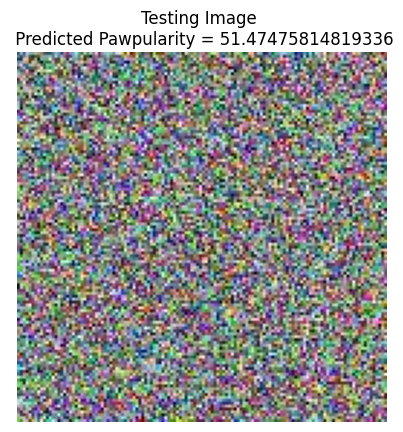

(128, 128, 3)


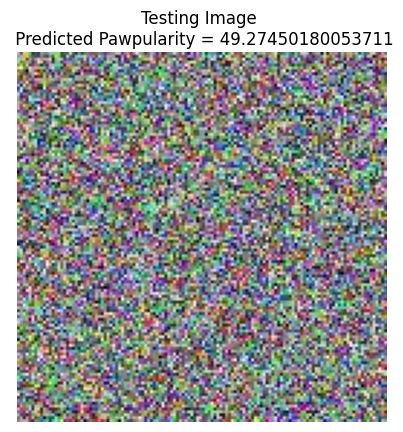

In [52]:
for i, image in enumerate(test_data['file_path'][:2]):
    testing_example_image = plt.imread(image) 
    print(testing_example_image.shape)
    #then plt.imshow() can display it for you
    plt.imshow(testing_example_image)
    plt.title('Testing Image \n Predicted Pawpularity = {}'.format(sample_submission['Pawpularity'].iloc[i]))
    plt.axis('off') #turns off the gridlines
    plt.show()